<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [2]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [11]:
# datos
df= pd.read_csv('data/cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [43]:
'''gate_30 = df[df["version"]=="gate_30"].count()
gate_30.head(2)'''
df.groupby('version').count()


,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [42]:
'''gate_40 = df[df["version"]=="gate_40"].count()
gate_40.head(2)'''


'gate_40 = df[df["version"]=="gate_40"].count()\ngate_40.head(2)'

<AxesSubplot:>

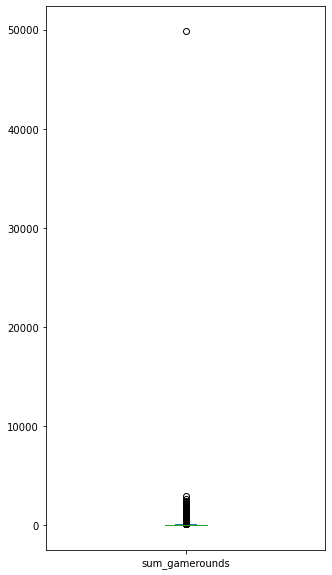

In [44]:
# transformacion
df['sum_gamerounds'].plot.box(figsize=(5,10))


In [46]:
# muestreo
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Text(0.5, 0, '# Game rounds')

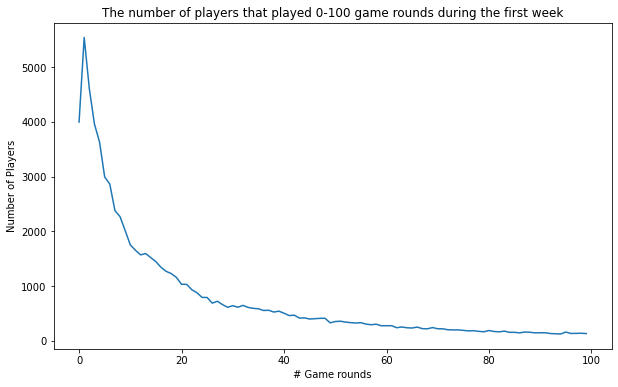

In [47]:
ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

In [48]:
# testeo para retention_1
df['retention_1'].sum() / df['retention_1'].count() 

0.4452095044850259

In [49]:
df.groupby('version')['retention_1'].mean()


version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

<AxesSubplot:ylabel='Density'>

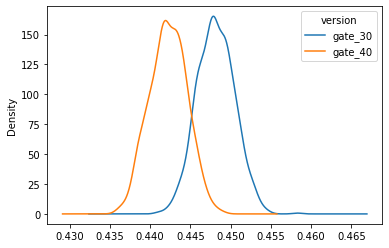

In [50]:
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

In [5]:
# testeo para retention_7



In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.